In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Preparing the data

In [ ]:
#load the dataset
!pip3 install gdown
!gdown https://drive.google.com/uc?id=1-jrCS61Ru-fRWUe46ot5ZvHNOsagm3eF
!unzip /content/face_mask.zip

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [ ]:
import os
dir = 'Face Mask Dataset/'
train_dir = dir+"Train/"
test_dir = dir+"Test/"
val_dir = dir+"Validation/"

print('num_of_classes: {} /'.format(len(os.listdir(train_dir))),
      'name_of_classes: {}'.format(os.listdir(train_dir)))
print('num_of_train_withoutmask {}/'.format(len(os.listdir(train_dir+'WithoutMask'))),
      'num_of_train_withmask {}'.format(len(os.listdir(train_dir+'WithMask'))))

print('num_of_test_withoutmask {}/'.format(len(os.listdir(test_dir+'WithoutMask'))),
      'num_of_test_withmask {}'.format(len(os.listdir(test_dir+'WithMask'))))
print('num_of_val_withoutmask {}/'.format(len(os.listdir(val_dir+'WithoutMask'))),
      'num_of_val_withmask {}'.format(len(os.listdir(val_dir+'WithMask'))))

num_of_classes: 2 / name_of_classes: ['WithMask', 'WithoutMask']
num_of_train_withoutmask 5000/ num_of_train_withmask 5000
num_of_test_withoutmask 509/ num_of_test_withmask 483
num_of_val_withoutmask 400/ num_of_val_withmask 400


#Create DataGenerator

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import numpy as np

image_size = (128,128)
batch_size = 32



train_gen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,rotation_range=10,
                                                         rescale=1./255,featurewise_center=True, 
                                                         featurewise_std_normalization=True)
val_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,featurewise_center=True, 
                                                         featurewise_std_normalization=True)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,featurewise_center=True, 
                                                         featurewise_std_normalization=True)

train_ds = train_gen.flow_from_directory(train_dir,target_size=image_size,shuffle=True, 
                                         batch_size=batch_size,seed=42, class_mode='categorical')
val_ds = val_gen.flow_from_directory(val_dir,target_size=image_size,shuffle=True, 
                                     batch_size=batch_size,seed=42, class_mode='categorical')
test_ds = test_gen.flow_from_directory(test_dir,target_size=image_size,shuffle=False,
                                       batch_size=batch_size, class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


#Create Model

In [ ]:
!pip install keras_efficientnets

In [ ]:
import time
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import random
import collections
from collections import defaultdict
import keras
from keras import layers 
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import callbacks

In [ ]:
def efficientNet(input_shape=(224, 224, 3)):
    model = EfficientNetB0(include_top=False,input_shape=input_shape, weights='imagenet')
    x = keras.layers.GlobalAveragePooling2D()(model.output)
    x = keras.layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    output = keras.layers.Dense(2, activation="softmax", name="pred")(x)
    model = keras.models.Model(inputs=[model.input], outputs=[output])

    return model

#Model visualization

In [ ]:
model = efficientNet(input_shape=(224, 224, 3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 224, 224, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_3[0][0]            
____________________________________________________________________________________________

#Model fit

In [ ]:
epochs=15
train_numbers=10000
val_numbers=800
test_numbers=992
image_size = (224, 224)
lr = 0.00001
batch_size = 32

In [ ]:
model_histories = []
models = efficientNet(input_shape=(224, 224, 3))
names = 'EfficientnetB0'

# Clear any logs from previous runs
LOGS_PATH="logs/"+names+"/"
!rm -rf "$LOGS_PATH"/*

## time mess
start=time.perf_counter()

# define log of tensorboard
logdir = "logs/"+names+"/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = TensorBoard(log_dir=logdir)
## End time mess

# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=lr)

# define checkpoint
checkpoint_filepath = names+'.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=False,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True, 
                                        verbose=1)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics='accuracy')
Earlystop =EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 5,verbose = 1,
                                            restore_best_weights = True)
model_histories.append(model.fit_generator(generator=train_ds, 
                                        validation_data=val_ds, epochs=epochs,
                                        callbacks=[Earlystop,tensorboard_callback, model_checkpoint_callback],
                                        steps_per_epoch=train_numbers//batch_size, 
                                        validation_steps=val_numbers//batch_size))
stop=time.perf_counter()
#model.save('CNN1.h5')
print('{:0.4f} mins elapsed'.format((stop-start)/60))
np.save('my_history_'+names+'.npy',model_histories[0].history) #for save acc and loss history

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/15
312/312 [==============================] - 168s 419ms/step - loss: 0.5194 - accuracy: 0.7809 - val_loss: 0.6926 - val_accuracy: 0.5638

Epoch 00001: val_loss improved from inf to 0.69264, saving model to EfficientnetB0.h5
Epoch 2/15
312/312 [==============================] - 129s 412ms/step - loss: 0.1303 - accuracy: 0.9603 - val_loss: 0.2828 - val_accuracy: 0.9300

Epoch 00002: val_loss improved from 0.69264 to 0.28276, saving model to EfficientnetB0.h5
Epoch 3/15
312/312 [==============================] - 129s 412ms/step - loss: 0.0745 - accuracy: 0.9795 - val_loss: 0.1091 - val_accuracy: 0.9737

Epoch 00003: val_loss improved from 0.28276 to 0.10909, saving model to EfficientnetB0.h5
Epoch 4/15
312/312 [==============================] - 129s 412ms/step - loss: 0.0592 - accuracy: 0.9821 - val_loss: 0.1555 - val_accuracy: 0.9513

Epoch 00004: val_loss did not improve from 0.10909
Epoch 5/15
312/312 [==============================] - 128s 410ms/step - loss: 0.0472 - accuracy

#Testing and performance report

In [ ]:
"""function for plotting confusion matrix"""

from sklearn.metrics import confusion_matrix
from mpl_toolkits import axes_grid1
import itertools
import matplotlib.pyplot as plt
from matplotlib import rcParams

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def plot_confusion_matrix(cm, classes, fontsize=20,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        None
        #print('Confusion matrix, without normalization')

    #print(cm)
    rcParams['figure.figsize'] = (15.0, 11.5)
    fig,ax = plt.subplots(figsize=(8,8))
    plt.grid(False)
    

    # Plot Training Confusion Matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.colorbar()
    add_colorbar(im)
    plt.title(title.replace('_',' ').title()+'\n', size=fontsize)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, size=fontsize)
    plt.yticks(tick_marks, classes, size=fontsize)
    plt.setp(ax.get_yticklabels(), rotation=90, ha="center",rotation_mode="anchor")

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Set color parameters
        color = "white" if cm[i, j] > thresh else "black"
        alignment = "center"

        # Plot numeric
        plt.text(j, i, format(cm[i, j], fmt),fontsize=fontsize,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label'.title(), size=fontsize)
    plt.xlabel('Predicted label'.title(), size=fontsize)

    return

def performance_report(test_ds):
    #Confution Matrix and Classification Report
    from sklearn.metrics import classification_report, confusion_matrix
    Y_pred = model.predict_generator(test_ds)
    y_pred = np.argmax(Y_pred, axis=1)
    print('Confusion Matrix')
    cnf_matrix = confusion_matrix(test_ds.classes, y_pred)
    print(cnf_matrix)
    print('Classification Report')
    target_names = [class_names[0], class_names[1]]
    print(classification_report(test_ds.classes, y_pred, target_names=target_names, digits=5))

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, fontsize=15, classes=target_names,
                        title='Confusion matrix, without normalization')
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, fontsize=15, classes=target_names, normalize=True,
                        title='Normalized confusion matrix')

Found 992 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Accuracy on test set: 0.9959677457809448
Loss on test set: 0.014938819222152233


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[483   0]
 [  4 505]]
Classification Report
              precision    recall  f1-score   support

    WithMask    0.99179   1.00000   0.99588       483
 WithoutMask    1.00000   0.99214   0.99606       509

    accuracy                        0.99597       992
   macro avg    0.99589   0.99607   0.99597       992
weighted avg    0.99600   0.99597   0.99597       992



<Figure size 432x288 with 0 Axes>

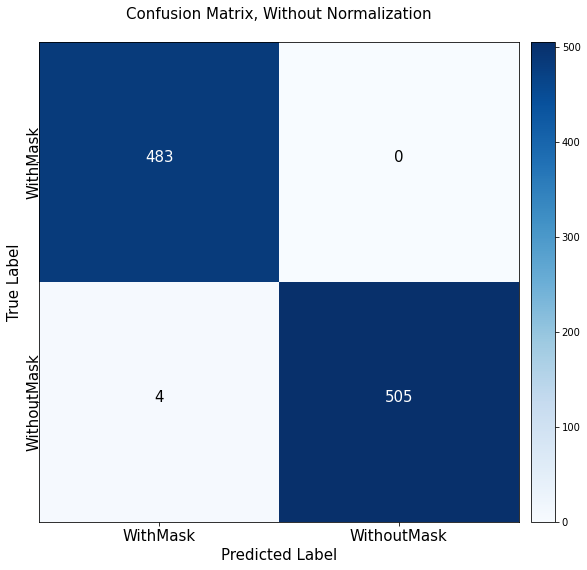

<Figure size 1080x828 with 0 Axes>

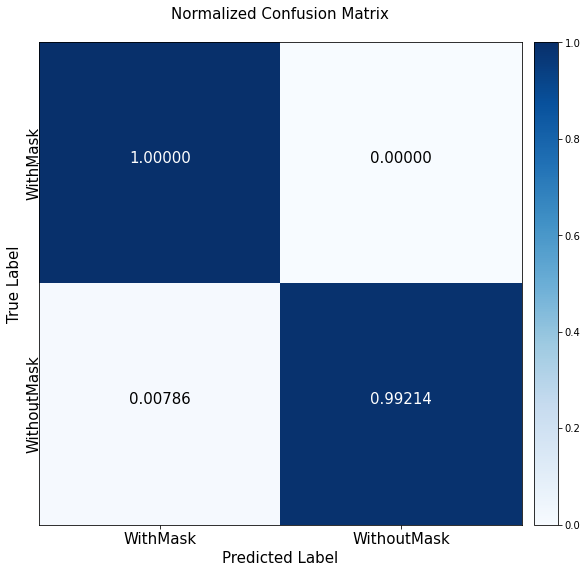

In [ ]:
test_con = test_gen.flow_from_directory(test_dir,target_size=image_size,shuffle=False,
                                        batch_size=batch_size, class_mode='categorical')
model = keras.models.load_model(names+'.h5')
score= model.evaluate_generator(test_con)
print('Accuracy on test set:', score[1])
print('Loss on test set:', score[0])
performance_report(test_con)

In [ ]:
%load_ext tensorboard
LOGS_PATH="logs/"+names
%tensorboard --logdir "$LOGS_PATH"/